In [43]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing #to transform the feature labels
from sklearn.feature_extraction import DictVectorizer #to turn categorial variables into numeric arrays
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random as rnd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC

In [3]:
train_set = pd.read_csv("Lab5_train.csv")
test_set = pd.read_csv("Lab5_test.csv")
train_set.head()

,PassengerID,Survived,Pclass,Name,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked
0,1302,0,3,"Youseff, Mr. Gerious",male,45.5,0,0,2628,7.2250,NaN,C
1,369,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.0000,NaN,S
2,1128,0,3,"Petroff, Mr. Nedelio",male,19.0,0,0,349212,7.8958,NaN,S
3,491,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S
4,1087,0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S


### Part 1: Feature & Model Exploration/Testing

#### Feature Exploration

Checking majority in train set

In [4]:
len(train_set[train_set["Survived"] == 1])/len(train_set) * 100

38.68852459016394

In [5]:
len(train_set[train_set["Survived"] == 0])/len(train_set) * 100

61.31147540983607

So, approx 61% didnt survive and 39% survived.

In [19]:
# Create Dataframes
df_train = train_set
df_test = test_set
df_combine = [df_train,df_test]

In [8]:
# Analyzing Pclass
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.657895
1,2,0.412371
2,3,0.251521


In [9]:
# Analyzing Sex
df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.750000
1,male,0.187817


In [10]:
# Analyzing Siblings and Spouse
df_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.528302
2,2,0.400000
0,0,0.353407
3,3,0.307692
4,4,0.176471
5,5,0.000000
6,8,0.000000


In [11]:
# Analyzing Parent Children
df_train[["ParCh", "Survived"]].groupby(['ParCh'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,ParCh,Survived
3,3,0.750000
1,1,0.614679
2,2,0.530864
0,0,0.338028
4,4,0.200000
5,5,0.000000
6,6,0.000000


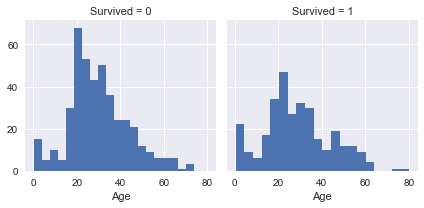

In [15]:
# Age and Survive
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

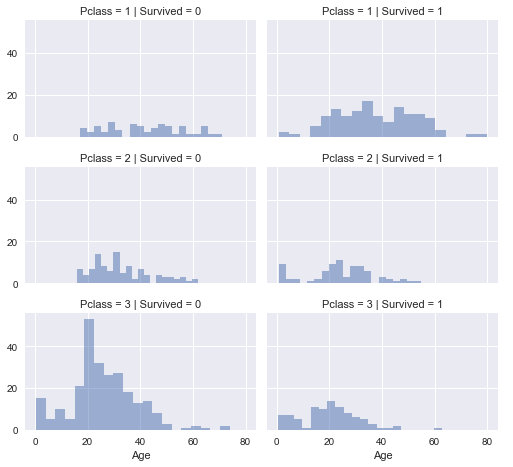

In [16]:
# Pclass and Survival
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

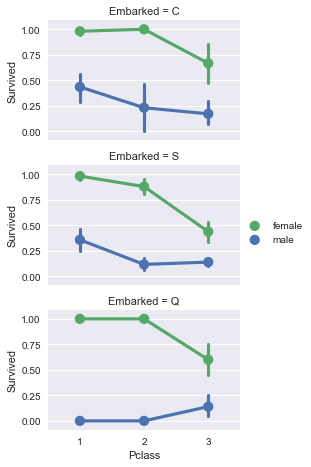

In [17]:
# Sex, Embarked and Survived
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

In [20]:
# Create Title Feature
for dataset in df_combine:
    dataset['Title'] = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
pd.crosstab(df_train['Title'], df_train['Sex'])

# Convert odd titles to 'Rare'
for dataset in df_combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

# Convert categorial titles to ordinal
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in df_combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


In [21]:
# Remove Name and PassengerID
df_train = df_train.drop(['Name', 'PassengerID'], axis=1)
df_test = df_test.drop(['Name'], axis=1)
df_combine = [df_train, df_test]

In [22]:
# Convert Sex to numerical values
for dataset in df_combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Title
0,0,3,0,45.5,0,0,2628,7.2250,NaN,C,1
1,0,2,0,37.0,1,0,SC/AH 29037,26.0000,NaN,S,1
2,0,3,0,19.0,0,0,349212,7.8958,NaN,S,1
3,0,2,1,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,3
4,0,3,1,31.0,0,0,350407,7.8542,NaN,S,2


In [25]:
# Populate Ages
guess_ages = np.zeros((2,3))
guess_ages

for dataset in df_combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_mean = guess_df.mean()
            age_std = guess_df.std()
            age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            #age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

In [26]:
df_train['AgeBand'] = pd.cut(df_train['Age'], 20)
df_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 4]",0.594595
1,"(4, 8]",0.562500
2,"(8, 12]",0.428571
3,"(12, 16]",0.612903
4,"(16, 20]",0.419753
5,"(20, 24]",0.394958
6,"(24, 28]",0.329268
7,"(28, 32]",0.379310
8,"(32, 36]",0.477064
9,"(36, 40]",0.151899


In [27]:
bins = np.arange(4,81,4)
bins

array([ 4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68,
       72, 76, 80])

In [28]:
# Convert Age to Age Bands
for dataset in df_combine:
    for i in np.arange(19):
        lower = bins[i]
        upper = bins[i+1]
        if (i != 19): dataset.loc[(dataset['Age'] > lower) & (dataset['Age'] <= upper), 'Age'] = i
        else: dataset.loc[(dataset['Age'] > lower)] = i
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked,Title,AgeBand
0,0,3,0,10,0,0,2628,7.2250,NaN,C,1,"(44, 48]"
1,0,2,0,8,1,0,SC/AH 29037,26.0000,NaN,S,1,"(36, 40]"
2,0,3,0,3,0,0,349212,7.8958,NaN,S,1,"(16, 20]"
3,0,2,1,13,0,0,S.O./P.P. 3,10.5000,E77,S,3,"(56, 60]"
4,0,3,1,6,0,0,350407,7.8542,NaN,S,2,"(28, 32]"


In [29]:
df_train = df_train.drop(['AgeBand'], axis=1)
df_combine = [df_train, df_test]

In [30]:
# Create Family Size feature
for dataset in df_combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['ParCh'] + 1

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.758621
2,3,0.557692
1,2,0.555556
4,5,0.333333
0,1,0.307829
6,7,0.272727
5,6,0.190476
7,8,0.000000
8,11,0.000000


In [31]:
# Create No Family feature
for dataset in df_combine:
    dataset['NoFamily'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'NoFamily'] = 1

df_train[['NoFamily', 'Survived']].groupby(['NoFamily'], as_index=False).mean()

,NoFamily,Survived
0,0,0.512748
1,1,0.307829


In [32]:
# Drop SibSp and ParCh
df_train = df_train.drop(['ParCh', 'SibSp'], axis=1)
df_test = df_test.drop(['ParCh', 'SibSp'], axis=1)
df_combine = [df_train, df_test]

df_train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,NoFamily
0,0,3,0,10,2628,7.2250,NaN,C,1,1,1
1,0,2,0,8,SC/AH 29037,26.0000,NaN,S,1,2,0
2,0,3,0,3,349212,7.8958,NaN,S,1,1,1
3,0,2,1,13,S.O./P.P. 3,10.5000,E77,S,3,1,1
4,0,3,1,6,350407,7.8542,NaN,S,2,1,1


In [33]:
# Populate Embarked feature
embark_array = df_train.Embarked.dropna().values
embark_array.sort()

for dataset in df_combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(embark_array[np.random.randint(0, len(embark_array)+1)])

df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.561798
1,Q,0.380435
2,S,0.339535


In [34]:
# Convert Embarked into numerical values
for dataset in df_combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
df_train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,NoFamily
0,0,3,0,10,2628,7.2250,NaN,1,1,1,1
1,0,2,0,8,SC/AH 29037,26.0000,NaN,0,1,2,0
2,0,3,0,3,349212,7.8958,NaN,0,1,1,1
3,0,2,1,13,S.O./P.P. 3,10.5000,E77,0,3,1,1
4,0,3,1,6,350407,7.8542,NaN,0,2,1,1


In [35]:
# Create New Fare
for dataset in df_combine:
    ticketName = dataset['Ticket'].unique()
    for name in ticketName:
        dataset.loc[dataset.Ticket == name,'Fare'] = dataset[dataset.Ticket == name].Fare/dataset[dataset.Ticket == name].Fare.count()
df_train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,NoFamily
0,0,3,0,10,2628,7.2250,NaN,1,1,1,1
1,0,2,0,8,SC/AH 29037,26.0000,NaN,0,1,2,0
2,0,3,0,3,349212,7.8958,NaN,0,1,1,1
3,0,2,1,13,S.O./P.P. 3,5.2500,E77,0,3,1,1
4,0,3,1,6,350407,7.8542,NaN,0,2,1,1


In [36]:
# Populate Empty Fare Sample
df_train.loc[df_train.Ticket == '3701','Fare'] = df_train[df_train.Pclass == 3].Fare.mean()

In [37]:
# Drop Ticket and Cabin
df_train = df_train.drop(['Ticket', 'Cabin','NoFamily'], axis=1)
df_test = df_test.drop(['Ticket', 'Cabin','NoFamily'], axis=1)
df_combine = [df_train, df_test]
df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,0,10,7.2250,1,1,1
1,0,2,0,8,26.0000,0,1,2
2,0,3,0,3,7.8958,0,1,1
3,0,2,1,13,5.2500,0,3,1
4,0,3,1,6,7.8542,0,2,1


In [40]:
# Determine Correlations
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test  = df_test.drop("PassengerID", axis=1).copy()

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

coeff_df = pd.DataFrame(df_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.150807
5,Title,0.530174
4,Embarked,0.152865
3,Fare,0.014436
2,Age,-0.143853
6,FamilySize,-0.257517
0,Pclass,-0.893448


#### Model Exploration

In [41]:
# Support Vector Machines

svc = svm.SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

85.790000000000006

In [44]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

86.230000000000004

In [45]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.560000000000002

In [46]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

61.969999999999999

In [47]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

81.200000000000003

In [48]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

80.109999999999999

In [49]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

95.629999999999995

In [50]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

95.519999999999996

In [51]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
8,Decision Tree,95.63
3,Random Forest,95.52
1,KNN,86.23
0,Support Vector Machines,85.79
7,Linear SVC,81.20
2,Logistic Regression,80.55
6,Stochastic Gradient Decent,80.11
4,Naive Bayes,79.56
5,Perceptron,61.97


### Part 2: Feature Selection & Model Training

### Feature Extraction & Selection
* Using Pclass, Sex, Age, SubSp, parCh to train model
* Adding additional features Fare, Embarked and Ticket reduced the accuracy
* Finally, combining SibSp and ParCh to FamilySize increased the accuracy somewhat

In [5]:
train_set['FamilySize'] = train_set['SibSp'] + train_set['ParCh']
test_set['FamilySize'] = test_set['SibSp'] + test_set['ParCh']

In [6]:
target = train_set.Survived

Encoding categorical features

In [7]:
vec = DictVectorizer()
train_sex_non_class = vec.fit_transform(train_set[['Sex']].to_dict('records')).toarray()
test_sex_non_class = vec.fit_transform(test_set[['Sex']].to_dict('records')).toarray()

Replace blank values of age

In [8]:
train_set['Age'].fillna(train_set['Age'].mean(), inplace=True)
test_set['Age'].fillna(test_set['Age'].mean(), inplace=True)

Scale feature values

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
train_set_age_scaled = min_max_scaler.fit_transform(train_set.Age)
test_set_age_scaled = min_max_scaler.fit_transform(test_set.Age)
min_max_scaler2 = preprocessing.MinMaxScaler()
train_set_pclass_scaled = min_max_scaler2.fit_transform(train_set.Pclass)
test_set_pclass_scaled = min_max_scaler2.fit_transform(test_set.Pclass)
min_max_scaler3 = preprocessing.MinMaxScaler()
train_set_familysize_scaled = min_max_scaler3.fit_transform(train_set.FamilySize)
test_set_familysize_scaled = min_max_scaler3.fit_transform(test_set.FamilySize)

/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X

In [11]:
train_set_features = np.concatenate((train_sex_non_class, np.reshape(train_set_age_scaled,(915,1)), np.reshape(train_set_pclass_scaled,(915,1)), np.reshape(train_set_familysize_scaled,(915,1))), axis=1)
test_set_features = np.concatenate((test_sex_non_class, np.reshape(test_set_age_scaled,(394,1)), np.reshape(test_set_pclass_scaled,(394,1)), np.reshape(test_set_familysize_scaled,(394,1))), axis=1)
train_set_features                                  

array([[ 0.        ,  1.        ,  0.56694579,  1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.46025127,  0.5       ,  0.1       ],
       [ 0.        ,  1.        ,  0.23430994,  1.        ,  0.        ],
       ..., 
       [ 0.        ,  1.        ,  0.19665306,  1.        ,  0.        ],
       [ 0.        ,  1.        ,  0.02092091,  0.5       ,  0.2       ],
       [ 0.        ,  1.        ,  0.00523054,  1.        ,  0.2       ]])

### Machine learning model training

#### Hyperparameter search for SVM

In [12]:
# Use Grid Search and cross validation to find the best hyperparameters (coarse grained search)
tuned_parameters = {'kernel': ['rbf'], 'C': [2**i for i in range(-5,16)], 'gamma': [2**i for i in range(-15,4)]}
clf1 = svm.SVC()
clf_coarse = GridSearchCV(clf1, tuned_parameters, cv=5)
clf_coarse.fit(train_set_features, target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768], 'gamma': [3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [13]:
best_c = math.log(clf_coarse.best_params_['C'], 2)
best_gamma = math.log(clf_coarse.best_params_['gamma'], 2)
print(best_c, best_gamma, clf_coarse.cv_results_['mean_test_score'].max())

14.0 -3.0 0.812021857923


In [14]:
# Use Grid Search and cross validation to find the best hyperparameters (fine grained search)
tuned_parameters = {'kernel': ['rbf'], 'C': [2**i for i in np.arange(best_c-2, best_c+2, 0.25)], 'gamma': [2**i for i in np.arange(best_gamma-2, best_gamma+2, 0.25)]}
clf1 = svm.SVC()
clf_fine = GridSearchCV(clf1, tuned_parameters, cv=5)
clf_fine.fit(train_set_features, target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': [4096.0, 4870.9923430511453, 5792.6187514801977, 6888.6234337584292, 8192.0, 9741.9846861022907, 11585.237502960395, 13777.246867516858, 16384.0, 19483.969372204581, 23170.475005920791, 27554.493735033717, 32768.0, 38967.938744409163, 46340.950011841582, 55108.987...29663689, 0.21022410381342863, 0.25, 0.29730177875068026, 0.35355339059327379, 0.42044820762685725]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
best_c = math.log(clf_fine.best_params_['C'], 2)
best_gamma = math.log(clf_fine.best_params_['gamma'], 2)
print(best_c, best_gamma, clf_fine.cv_results_['mean_test_score'].max())

13.25 -2.75 0.813114754098


#### Hyperparameter search for NN

In [16]:
# Use Grid Search and cross validation to find the best hyperparameters
tuned_parameters = {'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs','sgd', 'adam'], 'learning_rate' : ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes' : [val for val in zip(range(5,100,5),)]}
clf2 = MLPClassifier()
clf_coarse1 = GridSearchCV(clf2, tuned_parameters, cv=5)
clf_coarse1.fit(train_set_features, target)

/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/Users/rohitraghavan/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarni

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [(5,), (10,), (15,), (20,), (25,), (30,), (35,), (40,), (45,), (50,), (55,), (60,), (65,), (70,), (75,), (80,), (85,), (90,), (95,)], 'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'activation': ['logistic', 'tanh', 'relu']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [17]:
best_activation = clf_coarse1.best_params_['activation']
best_solver = clf_coarse1.best_params_['solver']
best_learning_rate = clf_coarse1.best_params_['learning_rate']
best_hidden_layer_size = clf_coarse1.best_params_['hidden_layer_sizes']
print(best_activation, best_solver, best_learning_rate, best_hidden_layer_size, clf_coarse1.cv_results_['mean_test_score'].max())

relu lbfgs adaptive (25,) 0.817486338798


#### Random Forest feature importance

In [18]:
clf3 = RandomForestClassifier(criterion='gini', n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
clf3.fit(train_set_features, target)
clf3.feature_importances_

array([ 0.23269874,  0.22538529,  0.28994907,  0.16175049,  0.09021642])

### Part 3: Ensemble methods

#### Voting classfier

In [53]:
clf1 = svm.SVC(kernel='rbf', C=2**best_c, gamma=2**best_gamma)
clf2 = MLPClassifier(activation=best_activation, solver=best_solver, learning_rate=best_learning_rate, hidden_layer_sizes=best_hidden_layer_size)
clf3 = RandomForestClassifier(criterion='gini', n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
eclf = VotingClassifier(estimators=[('svc', clf1), ('mlp', clf2), ('dc', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['SVM', 'Neural Network', 'Random Forest', 'Ensemble']):
   scores = cross_val_score(clf, train_set_features, target, cv=5, scoring='accuracy')
   print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.8131 (+/- 0.0137) [SVM]
Accuracy: 0.8142 (+/- 0.0134) [Neural Network]
Accuracy: 0.8120 (+/- 0.0103) [Random Forest]
Accuracy: 0.8175 (+/- 0.0175) [Ensemble]


#### Bagging

In [54]:
bagging = BaggingClassifier(n_estimators=100, max_samples=0.5, max_features=0.5)
scores = cross_val_score(bagging, train_set_features, target)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

Accuracy: 0.8066 (+/- 0.0214)


#### Adaboost

In [38]:
aclf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(aclf, train_set_features, target)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

Accuracy: 0.7934 (+/- 0.0161)


#### Stochastic Gradient Boosting

In [47]:
gclf = GradientBoostingClassifier(n_estimators=700, min_samples_split=10, min_samples_leaf=1, max_features='auto', random_state=1)
scores = cross_val_score(gclf, train_set_features, target)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

Accuracy: 0.7945 (+/- 0.0204)


#### Predict

In [41]:
eclf.fit(train_set_features, target)
target_predicted = eclf.predict(test_set_features)

#### Write to csv

In [42]:
output = pd.DataFrame({"PassengerId": test_set.PassengerID.values, 
              "Survived": target_predicted})
output.to_csv("submission_voting_classifier_normalized_f.csv", index=False)